# Computer Vision

## Task 1

Давай загрузим датасет CIFAR-10. Допиши функцию [load_dataloaders](./code-samples/cv_utils.py) с помощью [torchvision.datasets.CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)
и [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), чтобы функция возвращала
DataLoaderы для train и test частей датасета. \
C помощью функции `len` количество батчей в train_loader и test_loader.
> Для DataLoader параметры `transform` и `batch_size` оставьте по умолчанию.

In [36]:
import torch
import torchvision
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [37]:
BASE_TRANSFORM = transforms.Compose(
    [
        # Перевод изображений в тензоры
        transforms.ToTensor(),
        # Переводим цвета пикселей в отрезок [-1, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
BATCH_SIZE = 64 # Количество изображений в Батче
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Классы CIFAR10

In [38]:
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    
    test_set = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)
    
    return train_loader, test_loader

train_loader, test_loader = load_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


## Task 2

Узнай, как из объекта DataLoader можно получить изображения и метки. \
Передай первые 4 изображения и метки из первого батча тестовой выборки в функцию [imshow](./code-samples/cv_utils.py).
С помощью нее можно визуализировать датасет. \
Должна получиться примерно такая визуализация.
![sample](../misc/images/images_sample.png)
> Картинки и метки могут отличаться. Главное чтобы метки сходились с изображениями)

In [39]:
def imshow(images, labels, padding_size=15, labels_split_size=25):
    # убрать нормализацию
    img = images / 2 + 0.5    
    npimg = img.numpy()
    label_text = (' ' * labels_split_size).join('{}'.format(CLASSES[j]) for j in labels.tolist())
    print(' ' * padding_size + label_text)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.gcf().set_size_inches(20, 16)
    plt.show()

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


               bird                         plane                         dog                         dog


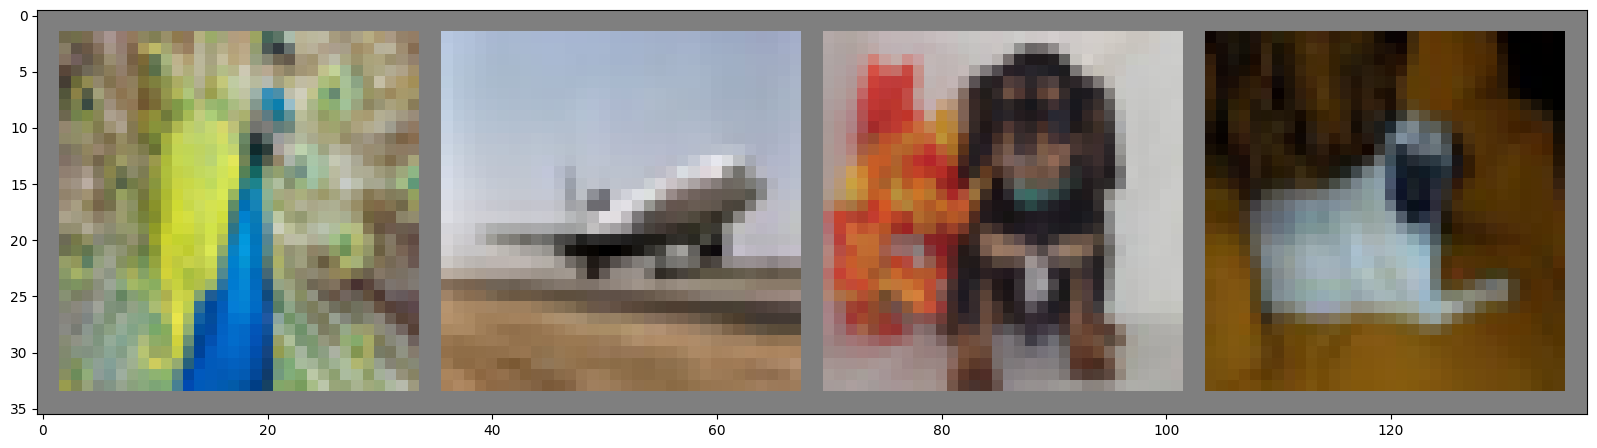

In [41]:
# Код тут
for images, labels in test_loader:
    # Отображаем первые 4 изображения и метки
    imshow(torchvision.utils.make_grid(images[:4]), labels[:4])
    break

## Task 3

Теперь попробуем написать небольшую сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Напишем сеть, основанную на одном блоке архитектуры [ResNet](https://arxiv.org/pdf/1512.03385.pdf) - Residual-Block. Схема этого блока приведена ниже:

<img src="../misc/images/rediual_block.png" width="500"/>

Допишите класс ResidualNet:
- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Также в сверточных слоях `padding = 1`

Функции, которые вам понадобяться: 
[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

Для базовой проверки, что сеть написана верно этот код не должен выдавать ошибку\
`assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)`

In [42]:
class ResidualNet(torch.nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.conv_3 = torch.nn.Conv2d(3, 32, 1)

        self.residual_block = torch.nn.Sequential( 
            torch.nn.Conv2d(3, 32, 1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, 1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )

        self.clf = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool2d(4), #8
            torch.nn.Flatten(1),
            torch.nn.Linear(512, n_classes)
        )

    def forward(self, x):
        out = self.residual_block(x)
        out = out + self.conv_3(x)
        out = self.clf(out)
        return out

In [43]:
# Код тут
net = ResidualNet()
assert net.forward(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

## Task 4

Перейдем к обучению сети. В этом вам поможет класс [Trainer](./code-samples/cv_utils.py).\
Для обучения кроме самой модели 
требуемся определить оптимизатор и функцию ошибок:
* В качестве оптимизатора выберите [стохастический градиентный спуск](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* В качестве функции ошибок
[кросс-энтропия](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Обучите сеть и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [44]:
class Trainer:
    
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        print('Сеть загружена на', self.device)
        
        self.optimizer = optimizer
        self.criterion = criterion

    def _train_epoch(self, train_loader):
        loss_log = []
        acc_log = []
        self.model.train()
        
        torch.autograd.set_detect_anomaly(True)

        for data, target in train_loader:
            data = data.to(self.device)

            if not isinstance(target, torch.Tensor):
                target = torch.tensor(target).to(self.device)
    
            self.optimizer.zero_grad()
            logits = self.model(data)

            loss = self.criterion(logits, target)
            loss.backward()
            self.optimizer.step()

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0]) 

        return np.mean(loss_log), np.mean(acc_log)

    def train(self, train_loader, test_loader, n_epochs):
        self.train_loss_log = [] 
        self.train_acc_log = [] 
        self.test_loss_log = []
        self.test_acc_log = []
    
        for epoch in range(n_epochs):
            start_time = time.time()
        
            train_loss, train_acc = self._train_epoch(train_loader)
            test_loss, test_acc = self.test(test_loader)

            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)

            self.test_loss_log.append(test_loss)
            self.test_acc_log.append(test_acc)

            end_time = time.time()
            epoch_time = end_time - start_time

            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" test loss: {test_loss}, test acc: {test_acc}")
            print(f" Epoch time: {epoch_time} seconds\n")
    
    def test(self, test_loader):
        loss_log = []
        acc_log = []
        self.model.eval()

        for data, target in test_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            with torch.no_grad():
                logits = self.model(data)
                loss = self.criterion(logits, target)

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0]) 

        return np.mean(loss_log), np.mean(acc_log)

In [45]:
def plot_train_log(trainer):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(trainer.train_loss_log) + 1), trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) + 1), trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(trainer.train_acc_log) + 1), trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) + 1), trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

In [46]:
# Код тут
n_epochs = 2
model = ResidualNet(n_classes=10)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
train_model = Trainer(model, optimizer, criterion)
# train_model._train_epoch(train_loader)
train_model.train(train_loader, test_loader, n_epochs)
# train_model.test(test_loader)

Сеть загружена на cpu


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 0
 train loss: 117.8792216698532, train acc: 0.3529012148337596
 test loss: 108.93409495585409, test acc: 0.4015944693094629
 Epoch time: 68.73203492164612 seconds



[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 1
 train loss: 106.34089534300978, train acc: 0.4187180306905371
 test loss: 103.23493939470453, test acc: 0.4367806905370844
 Epoch time: 71.4384548664093 seconds



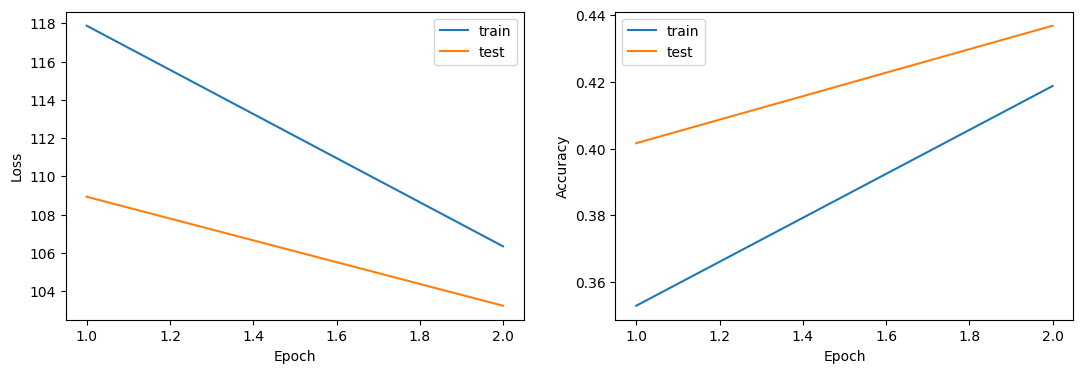

In [47]:
plot_train_log(train_model)

## Task 5

Одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. \
Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки,  тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.
Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке `transforms`, который затем передается в Dataloader.\
Изучи, какие [способы аугментаций](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) 
изображений можно использовать PyTorch. Выберите несколько из них и визуализируйте как изменился датасет. 
![sample](../misc/images/images_sample.png)
![sample](../misc/images/augment.png)

Обучите сеть с аугментацией данных и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [48]:
transform_v2 = transforms.Compose(
        [
            # Код тут
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(45),
            transforms.RandomCrop(size=(32, 32))
        ]
)

In [49]:
# Код тут

In [52]:
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_v2)    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    
    test_set = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform_v2)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)
    
    return train_loader, test_loader

train_loader, test_loader = load_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


In [53]:
n_epochs = 2
model = ResidualNet(n_classes=10)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
train_model = Trainer(model, optimizer, criterion)
# train_model._train_epoch(train_loader)
train_model.train(train_loader, test_loader, n_epochs)
# train_model.test(test_loader)

Сеть загружена на cpu


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 0
 train loss: 126.98496952934948, train acc: 0.2922194693094629
 test loss: 120.03952568327375, test acc: 0.3380754475703325
 Epoch time: 73.283931016922 seconds



[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch 1
 train loss: 117.58142384482771, train acc: 0.34622762148337594
 test loss: 115.77578473883821, test acc: 0.3541799872122762
 Epoch time: 73.7479498386383 seconds



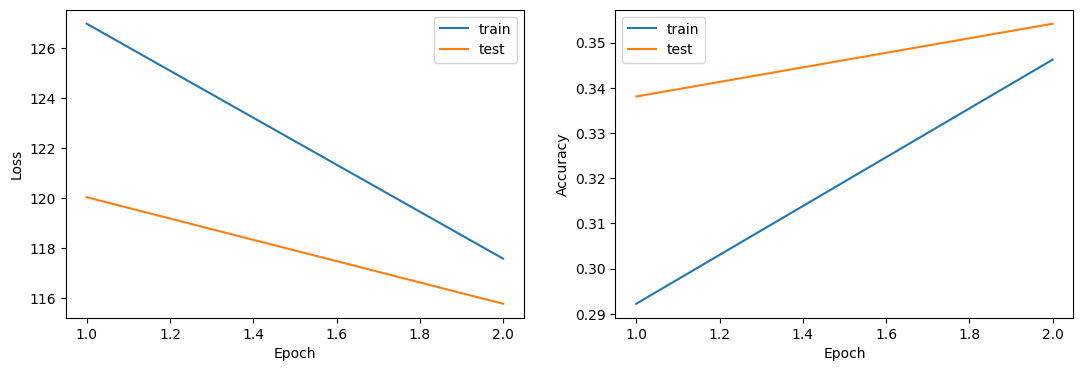

In [54]:
plot_train_log(train_model)